# 1D SVI with Derivative GP Prior
The derivative GP prior allows us to better control the shape of GP prior samples and hence the posterior distribution for the function that we are modelling with the GP.

## Example: 
Suppose we are dealing with a Poisson source whose intensity decreases when we make observations from it. The dataset will look appear as the plot below (with $x$ denoting time)

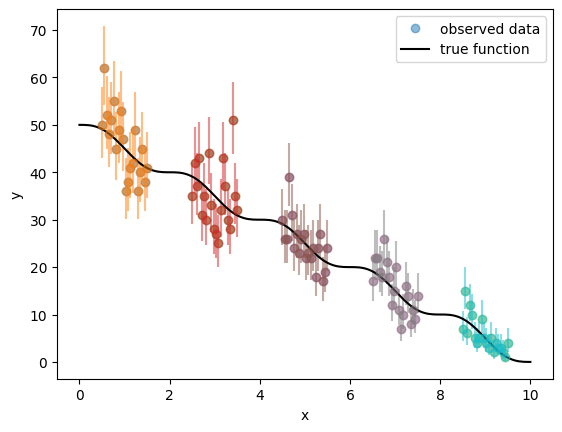

In [95]:
import sys
sys.path.append("..")
from utils import custom
from utils.custom import log_like_poisson, DerivativeKernel

import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting
import tqdm

import jax # for faster numerical operations
import jax.numpy as jnp # for numpy-like syntax
from jax.scipy import stats
from jax import jit

from tinygp import GaussianProcess, kernels
import numpyro # for inference and probabilistic programming
import numpyro.distributions as dist
from numpyro.infer import Predictive

# generate data
x_plt = jnp.linspace(0,10,201) # 10 random points between -1 and 1
y_plt = 5. * (10 - x_plt - jnp.sin(jnp.pi * (x_plt-1)) / jnp.pi)

# generate data
rng_key = jax.random.PRNGKey(23)
x_groups = []
y_obs_groups = []
for i in range(5):
    rng_key, key = jax.random.split(rng_key)
    x_group = jnp.linspace(2*i+1-0.5,2*i+2-0.5,20) # 10 random points between -1 and 1
    y_group = 5. * (10 - x_group - jnp.sin(jnp.pi * (x_group-1)) / jnp.pi)
    y_obs_group = jax.random.poisson(key,y_group)

    x_groups.append(x_group)
    y_obs_groups.append(y_obs_group)

x_groups = jnp.array(x_groups)
y_obs_groups = jnp.array(y_obs_groups)

x = x_groups.reshape(-1).copy()
y_obs = y_obs_groups.reshape(-1).copy()

# plot data with error bars
for i in range(5):
    if i == 0:
        plt.plot(x_groups[i], y_obs_groups[i], 'o', label='observed data', alpha = 0.5)
    else:
        plt.plot(x_groups[i], y_obs_groups[i], 'o', alpha = 0.5)
    # estimate error bars
    yerr = jnp.array([custom.poisson_interval(k) for k in y_obs_groups[i].T]).T
    plt.errorbar(x_groups[i], y_obs_groups[i], yerr=yerr, fmt='o', alpha = 0.5)

# plot true rate function
plt.plot(x_plt, y_plt, 'k', label='true function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Standard Gaussian Process Fit Without Derivative Observations

In [96]:
# Unconstrained SVI fit
def model(x, y=None):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)
    y : array
        y values (observations)
    '''
    # define GP kernel (with hyperparameters optimized during fitting)
    kernel = custom.load_kernel(before_fit = True)

    # define Gaussian Process prior on log_rate (zero mean and ExpSquared kernel)
    gp = GaussianProcess(kernel, x, diag = 1e-4)
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())
    rate = jnp.exp(log_rate)

    # load function values and compute log likelihood
    numpyro.factor('log_likelihood', log_like_poisson(rate, y))
    # numpyro.factor('log_likelihood', dist.Normal(loc = rate, scale = 4.).log_prob(y))

In [97]:
# run SVI
svi, guide = custom.load_svi(model, lr = 0.01, num_particles = 16)
rng_key = jax.random.PRNGKey(0)
svi_results = svi.run(rng_key, 30000, x, y=y_obs)

100%|██████████| 30000/30000 [00:24<00:00, 1212.60it/s, init loss: 411804.2812, avg. loss [28501-30000]: 312.4094]


In [98]:
# sample the GP at x using custom (vectorized) sampler that allows us to extrapolate
# from the observation times x to other times
rng_key, key = jax.random.split(rng_key)
pred = Predictive(guide, num_samples = 1, params = svi_results.params)
gp_samples = custom.extrapolate_gp(rng_key, 10000, pred, svi_results.params, x_plt, x)

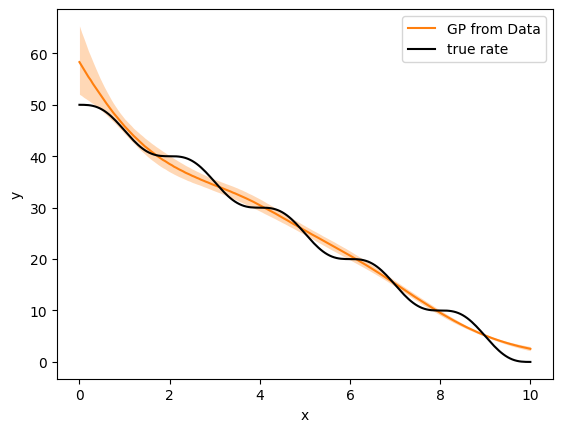

In [99]:
q = np.quantile(gp_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x_plt, np.exp(q[1]), color = 'C1', label = 'GP from Data')
plt.fill_between(
    x_plt,
    np.exp(q[0]),
    np.exp(q[2]),
    alpha=0.3,
    lw=0,
    color="C1",
)

# plot data with error bars 
plt.plot(x_plt, y_plt, "k", label="true rate")
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

## Regularizing the Fit with Derivatives

The standard gaussian process struggles to find the oscillations in the fit since the Poisson errors in the observations outweigh the effect of the oscillations in the true rate. 

However, suppose we have *a priori* knowledge that the source's intensity decreases when we make observations from it. Then, we should impose that the rate does not change significantly in times that we are not observing it. That is to say, we should be drawing samples from the GP posterior that have derivatives that are roughly zero when no observations are made. 

This is effectively done by adding a regularization term in the log-likelihood. For derivative values $f'_{i}$ evaluated at $x_{i, D}$, the regularization term we choose to add is:
$$ \log \mathcal{L_{\mathrm D}} = - \alpha_{D} \sum_{i} |f'_{i}|.$$
Therefore, non-zero derivatives at $x_{D}$ are penalized. For our choice of derivative inputs, $\alpha_{D} = 1$ performs well enough for our illustrative purposes.

**Note:** As discussed in the [sparse-tinygp][1] repo, we need to sample functions together with their derivatives. To avoid the derivative-part of the GP from being tracked by the SVI `guide`, we sample the function values first and only then sample derivatives from the GP conditioned on the values of the function at the observation inputs. To do this correctly, we need to provide a `PRNGKey` to the `GaussianProcess.sample` function that changes at each SVI step. We do this by running the fit using a custom SVI loop that manually adds the `PRNGKey` (see `utils/custom.py` for the `svi_loop` command). It is the same exact loop function used in the [sparse-tinygp][1].

<!-- ### References: -->

[1]: <https://github.com/edwarddramirez/sparse-tinygp> "sparse-tinygp"

In [100]:
# create set of points to impose zero derivatives
xp_groups = []
for i in range(6):
    rng_key, key = jax.random.split(rng_key)
    xp_group = jnp.linspace(2*i-0.25,2*i+1-0.75,5) # 10 random points between -1 and 1

    xp_groups.append(xp_group)

xp_groups = jnp.array(xp_groups)
xp = xp_groups.reshape(-1).copy()

mask = jnp.where( ~(xp < 0) & ~(xp > 10) )[0]
xp = xp[~mask]

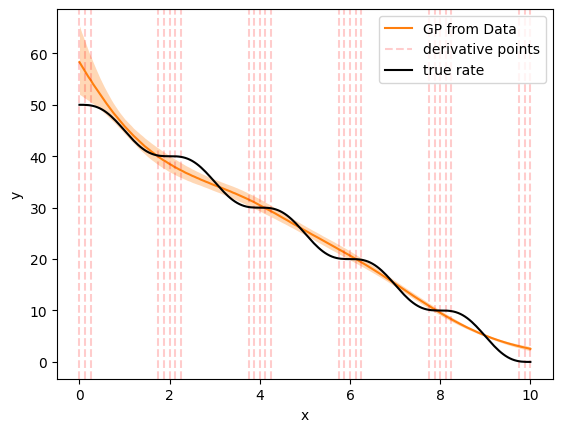

In [101]:
q = np.quantile(gp_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x_plt, np.exp(q[1]), color = 'C1', label = 'GP from Data')
plt.fill_between(
    x_plt,
    np.exp(q[0]),
    np.exp(q[2]),
    alpha=0.3,
    lw=0,
    color="C1",
)

# plot derivative points
for xp_v in xp:
    if xp_v == xp[0]:
        plt.axvline(xp_v, color="red", linestyle="--", alpha=0.2, label = 'derivative points')
    else:
        plt.axvline(xp_v, color="red", linestyle="--", alpha=0.2)
        
# plot data with error bars 
plt.plot(x_plt, y_plt, "k", label="true rate")
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

In [102]:
# Constrained SVI fit
def model(x, xp, y=None, gp_rng_key=jax.random.PRNGKey(0)):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)
    y : array
        y values (observations)
    '''
    # calculate number of observations
    Nx = x.shape[0] # number of points for function
    Np = xp.shape[0] # number of points for derivative

    # Set up the augmented input consisting of position and boolean for derivative
    # We augment observations in this way because the derivatives are evaluated
    # at different points than the inputs corresponding to observations
    x3 = jnp.concatenate([x,xp,xp]) 
    d3 = jnp.concatenate([jnp.zeros_like(x),jnp.zeros_like(xp),jnp.ones_like(xp)]) 
    x_aug = jnp.vstack([x3.T,d3.T]).T

    # define GP kernel (with hyperparameters optimized during fitting)
    base_kernel = custom.load_kernel(before_fit = True)
    kernel = DerivativeKernel(base_kernel)

    # define Gaussian Process prior on log_rate (zero mean and ExpSquared kernel)
    gp = GaussianProcess(kernel, x_aug[:Nx], diag = 1e-4)
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())
    rate = jnp.exp(log_rate)

    # load function values and compute log likelihood
    numpyro.factor('log_likelihood', log_like_poisson(rate, y))

    # sample log_rate_derivatives from GP conditioned on log_rate
    _, gp_cond = gp.condition(log_rate, x_aug[Nx:]) # condition GP on log_rate and sample derivatives at x_aug[Nx:]
    log_rate_aug = gp_cond.sample(key = gp_rng_key) # log_rate(xp), log_rate_deriv(xp) [new key added at each step via svi_loop fct]
    rate_xp = jnp.exp(log_rate_aug[:Np]) # rate(xp)
    log_rate_p = log_rate_aug[Np:] # rate_deriv(xp)
    rate_p = rate_xp * log_rate_p # rate_deriv
    numpyro.factor("constraint", -1. * jnp.sum(jnp.abs(rate_p)))

In [103]:
# run SVI
svi, guide = custom.load_svi(model, lr = 0.01, num_particles = 16)
rng_key = jax.random.PRNGKey(0)
svi_results = custom.svi_loop(rng_key, 30000, svi, x, xp, y_obs)

100%|██████████| 30000/30000 [00:33<00:00, 883.52it/s] 


In [104]:
# sample the GP at x using custom (vectorized) sampler
rng_key, key = jax.random.split(rng_key)
pred = Predictive(guide, num_samples = 1, params = svi_results.params)
gp_samples = custom.extrapolate_gp(rng_key, 10000, pred, svi_results.params, x_plt, x)

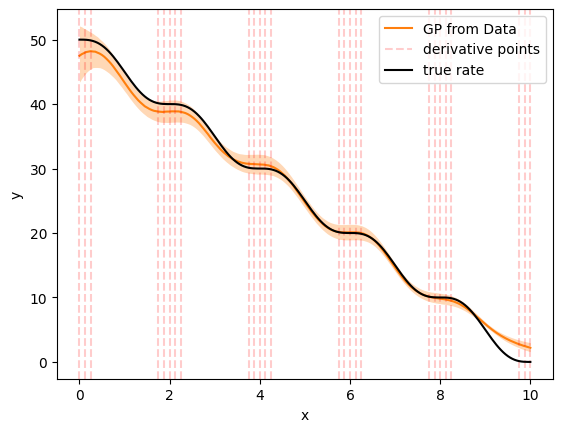

In [105]:
q = np.quantile(gp_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x_plt, np.exp(q[1]), color = 'C1', label = 'GP from Data')
plt.fill_between(
    x_plt,
    np.exp(q[0]),
    np.exp(q[2]),
    alpha=0.3,
    lw=0,
    color="C1",
)

# plot derivative points
for xp_v in xp:
    if xp_v == xp[0]:
        plt.axvline(xp_v, color="red", linestyle="--", alpha=0.2, label = 'derivative points')
    else:
        plt.axvline(xp_v, color="red", linestyle="--", alpha=0.2)

# plot data with error bars 
plt.plot(x_plt, y_plt, "k", label="true rate")
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

The regularization improves the fit significantly!